# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [41]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [42]:
# Load the dataset
netcdf_file_path = "Data/24_months_SSC_Data.nc"

# Open the data
dataset = xr.open_dataset(netcdf_file_path)

# Print head of dataset
dataset.head()

<xarray.Dataset> Size: 7kB
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 40B 2021-01-01 ... 2021-01-01T04:00:00
  * lat      (lat) float32 20B 35.74 35.77 35.79 35.81 35.83
  * lon      (lon) float32 20B 13.68 13.72 13.76 13.8 13.84
Data variables:
    u        (time, lat, lon) float64 1kB ...
    v        (time, lat, lon) float64 1kB ...
    stdu     (time, lat, lon) float64 1kB ...
    stdv     (time, lat, lon) float64 1kB ...
    cov      (time, lat, lon) float64 1kB ...
    velo     (time, lat, lon) float64 1kB ...
    head     (time, lat, lon) float64 1kB ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:45:58
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Conventions:             CF-1.4
    ...                                ...
    NC_GLOBAL.grid_resolution:         3.0km
    NC_GLOBAL.geospatial_lat_max:      36.8802
    NC_GLOBAL.geospatial_lat_min:      35.7447
    NC_GLOBAL.geospatial_lon_max:      15.3804
    NC_GLOBAL.geospatial_lon_min:      13.6768
    NC_GLOBAL.netcdf_library_version:  v2

In [43]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['v','stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove rows where 'u' has NaN values
df = df.dropna(subset=['u'])

df

,time,lat,lon,u
541,2021-01-01 00:00:00,36.011902,14.6908,-0.187088
542,2021-01-01 00:00:00,36.011902,14.7314,-0.250971
580,2021-01-01 00:00:00,36.034100,14.5286,0.079402
581,2021-01-01 00:00:00,36.034100,14.5692,-0.229349
584,2021-01-01 00:00:00,36.034100,14.6908,-0.394889
...,...,...,...,...
36858192,2022-12-31 23:00:00,36.880199,14.1230,0.327331
36858193,2022-12-31 23:00:00,36.880199,14.1635,0.400850
36858194,2022-12-31 23:00:00,36.880199,14.2041,0.460808
36858195,2022-12-31 23:00:00,36.880199,14.2447,0.578678


In [44]:
import pandas as pd

df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

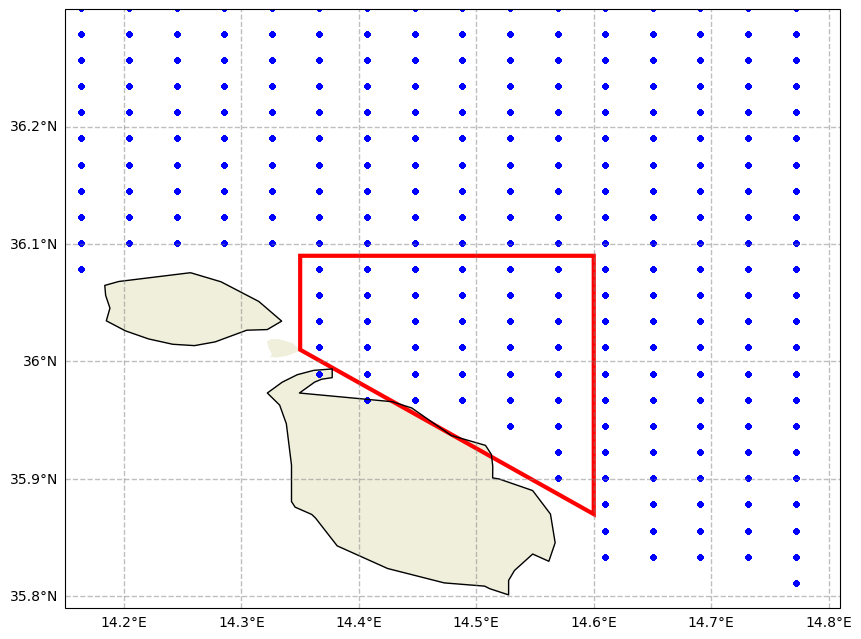

In [45]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting all points within the boundary from the dataframe 'df'
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create a red polygon and add it to the plot
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

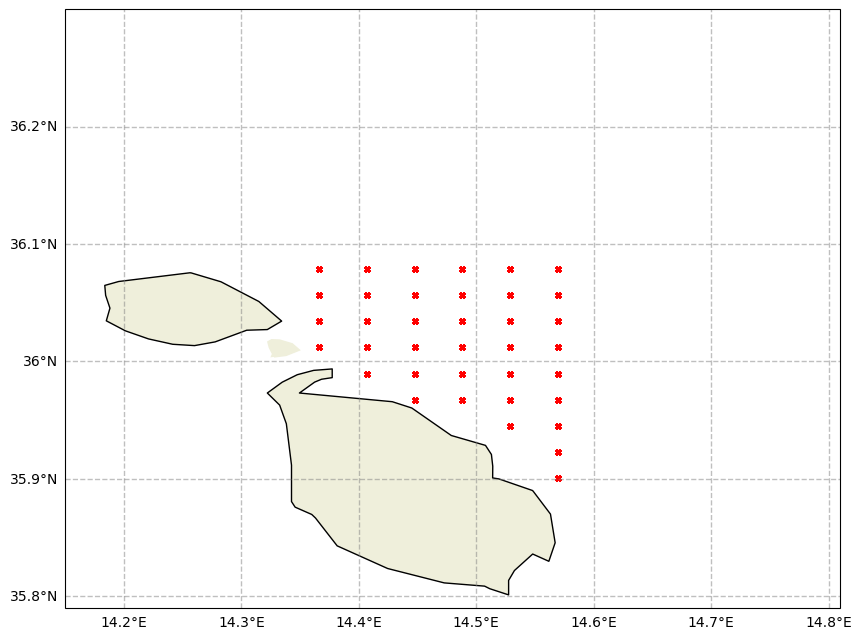

In [46]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to find points inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting only the points within the polygon
ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

In [47]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Prepare the coordinates as a list of tuples
coordinates = list(zip(df['lon'], df['lat']))

# Check if each coordinate is inside the polygon
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Filter the DataFrame for points within the polygon
df_inside_polygon = df[inside_mask]

# Removing potential duplicates
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Count the number of points inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Print out all of the coordinate pairs
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.528599739074707, 36.07870101928711)
(14.569199562072754, 36.07870101928711)
(14.447500228881836, 36.07870101928711)
(14.447500228881836, 36.056400299072266)
(14.406900405883789, 36.07870101928711)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.48799991607666, 36.07870101928711)
(14.48799991607666, 36.03409957885742)
(14.48799991607666, 36.056400299072266)
(14.569199562072754, 35.96730041503906)
(14.569199562072754, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.48799991607666, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.447500228881836, 36.01190185546875)
(14.366399765014648, 36.07870101928711)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.9

### Exctract data only for a single pair of coordinates

In [48]:
# Coordinates 
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame for the exact coordinates
df_point = df[(df['lat'] == target_lat) & (df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point

,time,lat,lon,u
time,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.0341,14.5286,0.079402
2021-01-01 13:00:00,2021-01-01 13:00:00,36.0341,14.5286,0.162881
2021-01-01 14:00:00,2021-01-01 14:00:00,36.0341,14.5286,0.144165
2021-01-01 15:00:00,2021-01-01 15:00:00,36.0341,14.5286,0.280085
2021-01-01 16:00:00,2021-01-01 16:00:00,36.0341,14.5286,0.115884
...,...,...,...,...
2022-12-31 19:00:00,2022-12-31 19:00:00,36.0341,14.5286,0.003522
2022-12-31 20:00:00,2022-12-31 20:00:00,36.0341,14.5286,0.000774
2022-12-31 21:00:00,2022-12-31 21:00:00,36.0341,14.5286,-0.030468


<Axes: xlabel='time'>

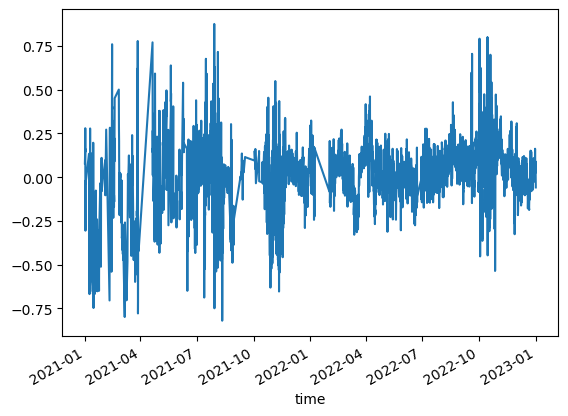

In [49]:
df1_u = df_point['u']
df1_u.plot()

In [50]:
import numpy as np

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = [] 
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [51]:
window_size = 5
X, y = df_to_X_y(df1_u, window_size=window_size)
X.shape, y.shape

((8842, 5, 1), (8842,))

In [52]:
import numpy as np

def train_val_test_split(X, y, train_size, val_size, test_size):
    # Calculate the indices for the end of each segment
    total_size = len(X)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)
    
    # Split the data
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Assuming X and y are defined and have the same order (time-wise)
train_size = 0.70
val_size = 0.15
test_size = 1 - (train_size + val_size)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_size, val_size, test_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6189, 5, 1), (6189,), (1326, 5, 1), (1326,), (1327, 5, 1), (1327,))

In [69]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer, Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.regularizers import l2

# Define the model
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(128, return_sequences=True))  # More units and return sequences for stacking LSTMs
model.add(Dropout(0.2))  # Regularization with dropout
model.add(LSTM(64, return_sequences=True))  # Stacking another LSTM layer
model.add(Dropout(0.2))  # Regularization with dropout
model.add(LSTM(32))  # Last LSTM does not return sequences
model.add(Dropout(0.2))  # Regularization with dropout
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [70]:
# Define ModelCheckpoint callback to save the best model
cp = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_single_target_best_model",
                     save_best_only=True,
                     monitor='val_loss',  
                     mode='min',  
                     verbose=0)   

# Compile the model
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001))

In [71]:
# Fit the model with the training data and validate with the validation data
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    callbacks=[cp])

Epoch 1/10
191/194 [============================>.] - ETA: 0s - loss: 0.1215
Epoch 1: val_loss improved from inf to 0.04962, saving model to Data/LSTM/Saved_Models\lstm_single_target_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


194/194 [==============================] - 18s 67ms/step - loss: 0.1206 - val_loss: 0.0496
Epoch 2/10
193/194 [============================>.] - ETA: 0s - loss: 0.0295
Epoch 2: val_loss improved from 0.04962 to 0.01667, saving model to Data/LSTM/Saved_Models\lstm_single_target_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


194/194 [==============================] - 10s 52ms/step - loss: 0.0295 - val_loss: 0.0167
Epoch 3/10
191/194 [============================>.] - ETA: 0s - loss: 0.0139
Epoch 3: val_loss improved from 0.01667 to 0.01051, saving model to Data/LSTM/Saved_Models\lstm_single_target_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


194/194 [==============================] - 11s 59ms/step - loss: 0.0140 - val_loss: 0.0105
Epoch 4/10
191/194 [============================>.] - ETA: 0s - loss: 0.0118
Epoch 4: val_loss improved from 0.01051 to 0.01032, saving model to Data/LSTM/Saved_Models\lstm_single_target_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


194/194 [==============================] - 36s 185ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 5/10
194/194 [==============================] - ETA: 0s - loss: 0.0114
Epoch 5: val_loss improved from 0.01032 to 0.00984, saving model to Data/LSTM/Saved_Models\lstm_single_target_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


194/194 [==============================] - 13s 65ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 6/10
191/194 [============================>.] - ETA: 0s - loss: 0.0109
Epoch 6: val_loss did not improve from 0.00984
194/194 [==============================] - 4s 18ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 7/10
191/194 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 7: val_loss improved from 0.00984 to 0.00954, saving model to Data/LSTM/Saved_Models\lstm_single_target_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_target_best_model\assets


194/194 [==============================] - 12s 60ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 8/10
192/194 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 8: val_loss did not improve from 0.00954
194/194 [==============================] - 3s 15ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 9/10
194/194 [==============================] - ETA: 0s - loss: 0.0110
Epoch 9: val_loss did not improve from 0.00954
194/194 [==============================] - 3s 15ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 10/10
191/194 [============================>.] - ETA: 0s - loss: 0.0107
Epoch 10: val_loss did not improve from 0.00954
194/194 [==============================] - 3s 15ms/step - loss: 0.0108 - val_loss: 0.0096


In [72]:
from keras.models import load_model

model = load_model("Data/LSTM/Saved_Models/lstm_single_target_best_model")

In [73]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals': y_val})
val_results

42/42 [==============================] - 2s 7ms/step


,Val Predictions,Actuals
0,0.130222,0.143341
1,0.137306,0.134769
2,0.134266,0.127329
3,0.128021,0.143499
4,0.136342,0.183848
...,...,...
1321,0.088675,-0.098120
1322,-0.034028,-0.098966
1323,-0.077373,-0.103497
1324,-0.079507,0.097919


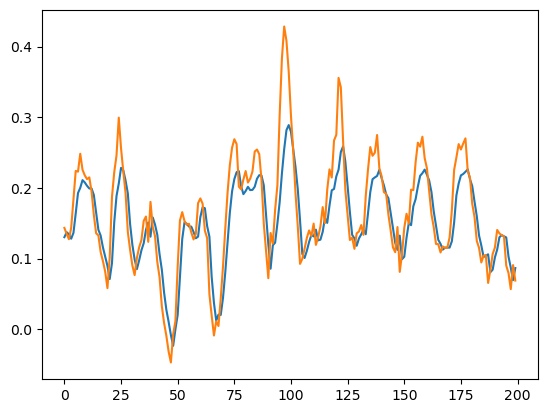

In [74]:
plt.plot(val_results['Val Predictions'][:200])
plt.plot(val_results['Actuals'][:200])

In [75]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test})
test_results

42/42 [==============================] - 0s 7ms/step


,Test Predictions,Actuals
0,0.148507,0.209414
1,0.181248,0.125163
2,0.138412,0.186031
3,0.163030,0.187845
4,0.176642,0.223268
...,...,...
1322,0.070729,0.003522
1323,0.029574,0.000774
1324,0.016173,-0.030468
1325,-0.005684,-0.026932


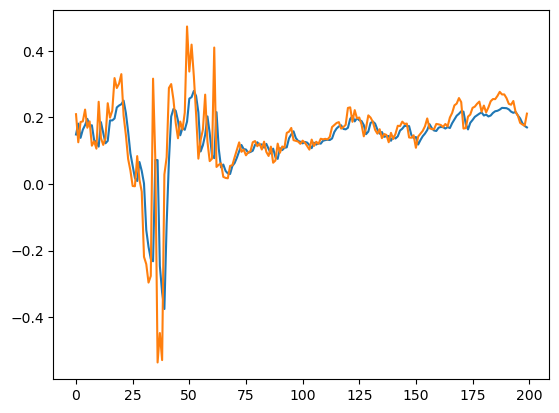

In [76]:
plt.plot(test_results['Test Predictions'][:200])
plt.plot(test_results['Actuals'][:200])